<a href="https://colab.research.google.com/github/simulate111/Supervised-Machine-Learning/blob/main/quiz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quiz 5 - Programming Excercises
## 1. Ensemble Learning


This exercise demonstrates the relationship between the true risk of individual weak learners and that of an ensemble of these learners in a binary classification setting, where the ensemble employs majority voting.

**Task 1a**: Complete the `ensemble_truerisk` function.

In [4]:
import numpy as np
from scipy.stats import binom

def ensemble_truerisk(nlearner=20, eps=0.2):
    """ compute the ensemble true risk

    Args:
        nlearner (int): number of weak learners
        eps (float): true risk of weak learners

    Returns:
        Rh (float): true risk of the ensemble
    """
    # Compute the probability of majority voting error
    majority = nlearner // 2 + 1
    Rh = 0.0

    for k in range(majority, nlearner + 1):
        Rh += binom.pmf(k, nlearner, eps)

    return Rh

In [ ]:
import numpy as np
from scipy.stats import binom

def ensemble_truerisk(nlearner=20, eps=0.2):
    """Compute the ensemble true risk.

    Args:
        nlearner (int): Number of weak learners.
        eps (float): True risk of each weak learner.

    Returns:
        Rh (float): True risk of the ensemble.
    """
    # Compute the probability of ensemble misclassification by summing over cases
    # where more than half of the learners make incorrect predictions.
    threshold = nlearner // 2 + 1
    Rh = sum(binom.pmf(k, nlearner, eps) for k in range(threshold, nlearner + 1))

    return Rh


**Task 1b**: Visualise the results, and answer question 2.

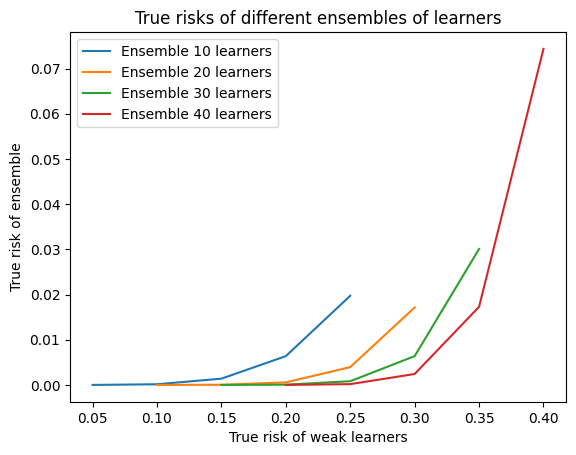

In [5]:
import matplotlib.pyplot as plt

neps = 5  # number of true risks of weak learners in the ensemble
nensemble = 4  # number of the ensembles
# number of weak learners in each ensembles
llearnerensembles = [(i+1) * 10 for i in range(nensemble)]
# values of the different true risk of weak learners
# assigned to each ensemble
xeps = np.zeros((nensemble, neps))
for i in range(nensemble):
    xeps[i] = np.linspace(0.05*(i+1), 0.2 + 0.05*(i+1), num=neps)

xtruerisk = np.zeros((nensemble, neps))

for i in range(nensemble):
    for ieps in range(neps):
        xtruerisk[i, ieps] = ensemble_truerisk(
            nlearner=llearnerensembles[i], eps=xeps[i, ieps])

# Visualise `xtruerisk`
for i in range(nensemble):
    plt.plot(xeps[i], xtruerisk[i], label=f'Ensemble {llearnerensembles[i]} learners')

plt.xlabel('True risk of weak learners')
plt.ylabel('True risk of ensemble')
plt.title('True risks of different ensembles of learners')
plt.legend()
plt.show()


## 2. Multi-Layer Perceptron (MLP)

This exercise compares the performance of Multi-Layer Perceptrons (MLP) in classification problems.

The code below creates two datasets, "Circles" and "Moons", from `sklearn`.

In [6]:
import numpy as np
from sklearn.datasets import make_circles, make_moons

# Datasets
data_names = ["Circles", "Moons"]
datasets = [
    make_circles(n_samples=500, noise=0.3, factor=0.5, random_state=0),
    make_moons(n_samples=500, noise=0.3, random_state=0)
]
ndataset = len(datasets)

The classifiers are created using methods from `sklearn`, with the hyperparameters set as follows.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Setting the learners parameters
# number of layers in the MLPs
lnlayers = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15]
# number of MLP learners
nlearner = len(lnlayers)
# total number of nodes: nlayer * nlayersize = C
nnodes = 120
# number of nodes per layer in the learners
lhyperparams = [(i+1, int(nnodes/(i+1))) for i in lnlayers]

# Hyperparameters of solvers
# maximum number of iterations
iteration = 1000
lsolvers = ['lbfgs', 'sgd', 'adam']
nsolver = len(lsolvers)
nfold = 5


# refrence list of learners
lclassifiers = []
for (nlayer, nnode) in lhyperparams:
    lmlpsolvers = []
    for ssolver in lsolvers:
        lmlpsolvers.append(
            make_pipeline(
                StandardScaler(),
                MLPClassifier(
                    solver=ssolver,
                    alpha=0.0001,
                    random_state=0,
                    max_iter=iteration,
                    early_stopping=False,
                    hidden_layer_sizes=[nnode for _ in range(nlayer)])
            )
        )
    lclassifiers.append(lmlpsolvers)

**Task 2**: Complete the code below and answer question 4.

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# collector of the results
xf1score = np.zeros((ndataset, nlearner, nsolver, nfold))

# iterate over datasets
for idata, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    # change y values from (0,1) to (-1,+1)
    y = 2*y - 1
    # scale the data
    m = X.shape[0]
    X /= np.outer(np.ones(m), np.max(np.abs(X), 0))

    for ilearner in range(nlearner):
        for isolver in range(nsolver):
            # set up the learners
            learner = lclassifiers[ilearner][isolver]

            # select training and test
            cselection = KFold(n_splits=nfold, random_state=None, shuffle=False)

            ifold = 0
            for index_train, index_test in cselection.split(X):
                # split the data into training and test
                X_train, X_test = X[index_train], X[index_test]
                y_train, y_test = y[index_train], y[index_test]

                # fit the model
                learner.fit(X_train, y_train)

                # predict
                y_pred = learner.predict(X_test)

                # compute scores
                xf1score[idata, ilearner, isolver, ifold] = f1_score(y_test, y_pred)

                ifold += 1

# average on folds
avg_f1score = np.mean(xf1score, axis=3)

# Print the average F1 scores for each dataset, learner, and solver
for idata, data_name in enumerate(data_names):
    print(f"Dataset: {data_name}")
    for ilearner, nlayer in enumerate(lnlayers):
        for isolver, solver in enumerate(lsolvers):
            print(f"  Layers: {nlayer}, Solver: {solver}, Avg F1 Score: {avg_f1score[idata, ilearner, isolver]:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.datasets import make_circles, make_moons
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Datasets
data_names = ["Circles", "Moons"]
datasets = [
    make_circles(n_samples=500, noise=0.3, factor=0.5, random_state=0),
    make_moons(n_samples=500, noise=0.3, random_state=0)
]
ndataset = len(datasets)

# Setting the learners parameters
lnlayers = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15]
nlearner = len(lnlayers)
nnodes = 120
lhyperparams = [(i+1, int(nnodes/(i+1))) for i in lnlayers]

# Hyperparameters of solvers
iteration = 2000  # Increased number of iterations
lsolvers = ['lbfgs', 'sgd', 'adam']
nsolver = len(lsolvers)
nfold = 5

# Reference list of learners
lclassifiers = []
for (nlayer, nnode) in lhyperparams:
    lmlpsolvers = []
    for ssolver in lsolvers:
        lmlpsolvers.append(
            make_pipeline(
                StandardScaler(),
                MLPClassifier(
                    solver=ssolver,
                    alpha=0.0001,
                    random_state=0,
                    max_iter=iteration,
                    early_stopping=False,
                    hidden_layer_sizes=[nnode for _ in range(nlayer)])
            )
        )
    lclassifiers.append(lmlpsolvers)

# Collector of the results
xf1score = np.zeros((ndataset, nlearner, nsolver, nfold))

# Iterate over datasets
for idata, ds in enumerate(datasets):
    # Preprocess dataset, split into training and test part
    X, y = ds
    # Change y values from (0,1) to (-1,+1)
    y = 2*y - 1

    for ilearner in range(nlearner):
        for isolver in range(nsolver):
            # Set up the learners
            learner = lclassifiers[ilearner][isolver]

            # Select training and test using KFold
            cselection = KFold(n_splits=nfold, random_state=None, shuffle=False)

            ifold = 0
            for index_train, index_test in cselection.split(X):
                # Split the data into training and test sets
                X_train, X_test = X[index_train], X[index_test]
                y_train, y_test = y[index_train], y[index_test]

                # Fit the model
                learner.fit(X_train, y_train)

                # Predict the labels for the test set
                y_pred = learner.predict(X_test)

                # Compute F1 score and store it
                xf1score[idata, ilearner, isolver, ifold] = f1_score(y_test, y_pred)

                ifold += 1

# Average on folds
avg_f1score = np.mean(xf1score, axis=3)

# Print the average F1 scores for each dataset, learner, and solver
for idata, data_name in enumerate(data_names):
    print(f"Dataset: {data_name}")
    for ilearner, nlayer in enumerate(lnlayers):
        for isolver, solver in enumerate(lsolvers):
            print(f"  Layers: {nlayer}, Solver: {solver}, Avg F1 Score: {avg_f1score[idata, ilearner, isolver]:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the true risks of different ensembles
plt.figure(figsize=(10, 6))

# Loop over each ensemble and plot its true risk curve
for i, n_learner in enumerate(llearnerensembles):
    plt.plot(xeps[i], xtruerisk[i], marker='o', label=f'Ensemble {i+1} ({n_learner} learners)')

# Labeling the plot
plt.xlabel('True Risk of Weak Learners')
plt.ylabel('True Risk of Ensemble')
plt.title('True Risks of Different Ensembles of Learners')
plt.legend(title='Ensemble Size', loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Collector for results
xf1score = np.zeros((ndataset, nlearner, nsolver, nfold))

# Iterate over datasets
for idata, ds in enumerate(datasets):
    # Preprocess dataset, split into training and test parts
    X, y = ds
    y = 2 * y - 1  # Convert y values from (0,1) to (-1,+1)
    m = X.shape[0]
    X /= np.outer(np.ones(m), np.max(np.abs(X), 0))  # Scale data

    for ilearner in range(nlearner):
        for isolver in range(nsolver):
            # Select classifier
            clf = lclassifiers[ilearner][isolver]

            # Perform K-Fold Cross-Validation
            cselection = KFold(n_splits=nfold, shuffle=True, random_state=0)
            ifold = 0

            for index_train, index_test in cselection.split(X):
                # Split data
                X_train, X_test = X[index_train], X[index_test]
                y_train, y_test = y[index_train], y[index_test]

                # Fit model
                clf.fit(X_train, y_train)

                # Predict and score
                y_pred = clf.predict(X_test)
                xf1score[idata, ilearner, isolver, ifold] = f1_score(y_test, y_pred)

                ifold += 1

# Average F1 scores across folds
avg_f1_scores = xf1score.mean(axis=3)

# Display results for debugging
print("Average F1 Scores across folds:")
print(avg_f1_scores)
